<a href="https://colab.research.google.com/github/GabrielaRomoM/DSP-2024-2/blob/main/Taller_2_%5B201124%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
# @title Libreria
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter
from ipywidgets import interact

# Taller 2 (PARTE 1):

1. Crear una señal con diferentes frecuencias (10,20,30,...,100 Hz).
2. Agregar Ruido Blanco Gaussiano (0.3).
3. Calcular FFT (Signal -> FFT = W).
4. Calcular a la FFT la inversa para obtener la señal original (W -> IFFT = Signal).
4. Crear un filtro (sin aplicar filtros, puede ser con un escalon, etc) y cortar armonicos de tal forma que queden solo 3 o 4 (W=W_f).
5. Aplicar a la señal con armonicos filtrados resultante la inversa para obtener la señal original pero sin los armonicos que fueron filtrados (W_f -> IFFT = Signal_filt).

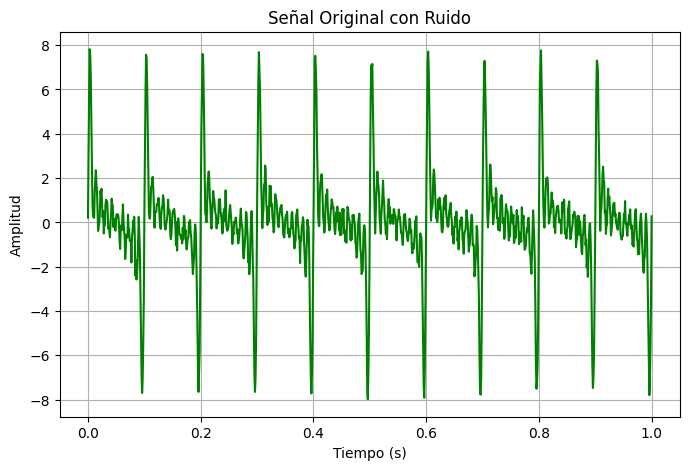

In [10]:
# Parámetros
fs = 1000  # Frecuencia de muestreo en Hz
t = 1  # Duración de la señal en segundos
fqs = np.arange(10,110,10)  # Frecuencias en la señal (10, 20, ..., 100 Hz)
noise = 0.3  # Desviación estándar del ruido blanco gaussiano

# Generar la señal con varias frecuencias
ts = np.linspace(0, t, fs*t)
s = sum(np.sin(2 * np.pi * f * ts) for f in fqs)

# Agregar ruido blanco gaussiano
ns = s + np.random.normal(0, noise, len(ts))

plt.figure(figsize=(8, 5))
# Señal original con ruido
plt.plot(ts, ns, color= 'g'), plt.xlabel("Tiempo (s)"), plt.ylabel("Amplitud")
plt.title("Señal Original con Ruido")
plt.grid()

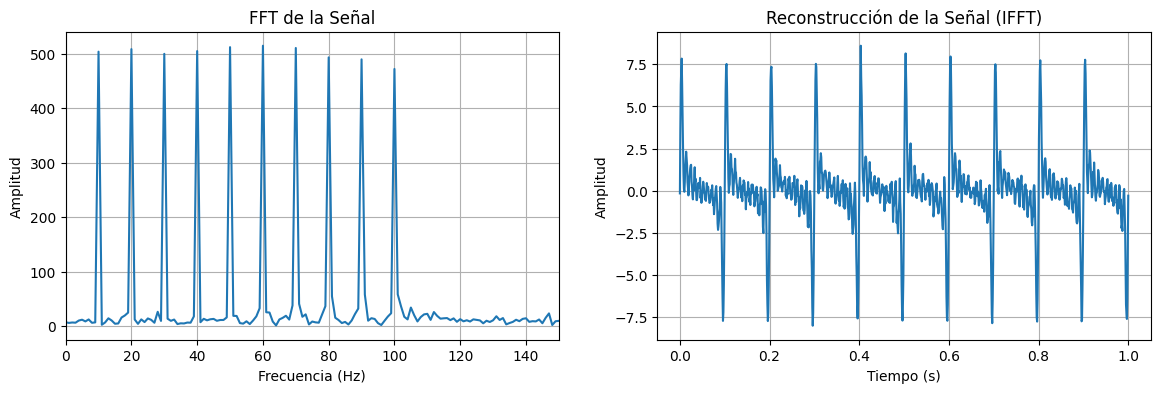

In [5]:
# Calcular FFT de la señal
W = np.fft.fft(ns)
freqs = np.fft.fftfreq(len(W), 1 / fs)
# Calcular la señal original desde la FFT (usando IFFT)
RSignal = np.fft.ifft(W)

plt.figure(figsize=(14, 4))
# FFT
plt.subplot(121), plt.plot(freqs[:len(freqs)//2], np.abs(W[:len(W)//2]))
plt.xlabel("Frecuencia (Hz)"), plt.ylabel("Amplitud"), plt.title("FFT de la Señal")
plt.xlim(0,150), plt.grid()
# Reconstrucción de la señal original desde FFT
plt.subplot(122), plt.plot(ts, RSignal.real)
plt.xlabel("Tiempo (s)"), plt.ylabel("Amplitud"), plt.title("Reconstrucción de la Señal (IFFT)")
plt.grid()

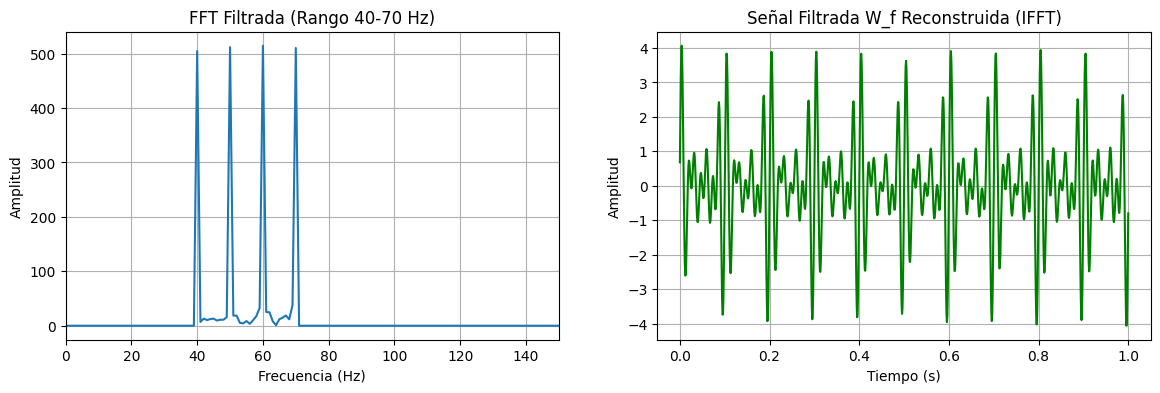

In [6]:
# Definir el rango de frecuencias permitido
low_cutoff = 40  # Frecuencia mínima permitida (Hz)
high_cutoff = 70  # Frecuencia máxima permitida (Hz)

# Crear el filtro tipo escalón
W_f = W.copy()
mask = (np.abs(freqs) >= low_cutoff) & (np.abs(freqs) <= high_cutoff)
W_f[~mask] = 0  # Poner a cero las frecuencias fuera del rango

# Reconstruir la señal filtrada usando la IFFT
s_filt = np.fft.ifft(W_f)

plt.figure(figsize=(14, 4))
# FFT Filtrada
plt.subplot(121), plt.plot(freqs[:len(freqs)//2], np.abs(W_f[:len(W_f)//2]))
plt.xlabel("Frecuencia (Hz)"), plt.ylabel("Amplitud"), plt.title("FFT Filtrada (Rango 40-70 Hz)")
plt.xlim(0,150), plt.grid()
# Señal filtrada en el dominio del tiempo
plt.subplot(122), plt.plot(ts, s_filt.real, color ='g')
plt.xlabel("Tiempo (s)"), plt.ylabel("Amplitud"), plt.title("Señal Filtrada W_f Reconstruida (IFFT)")
plt.grid()

# Taller 2 (PARTE 2):

- Realizar un ecualizador de 5 bandas.

In [21]:
# Función para aplicar filtro pasa banda
def band_pass_filter(signal, f_low, f_high, fs, order=4):
    nyquist = 0.5 * fs
    f_low = max(f_low, 1)  # Aseguramos que f_low > 0
    f_high = min(f_high, nyquist - 1)  # Aseguramos que f_high < Nyquist
    low = f_low / nyquist ; high = f_high / nyquist
    b, a = butter(order, [low, high], btype='band')
    return lfilter(b, a, signal)

In [24]:
# Función principal del ecualizador
@interact(band1=(-10, 10, 1), band2=(-10, 10, 1),
          band3=(-10, 10, 1), band4=(-10, 10, 1), band5=(-10, 10, 1))
def equalizer(band1=0, band2=0, band3=0, band4=0, band5=0):
    # Definir las bandas
    bands = [
        (0, 100),  # Banda 1
        (100, 200),  # Banda 2
        (200, 300),  # Banda 3
        (300, 400),  # Banda 4
        (400, 500),  # Banda 5
    ]

    gains = [band1, band2, band3, band4, band5]
    # Procesar cada banda con sus ganancias
    filtered_signals = []
    for (f_low, f_high), gain in zip(bands, gains):
        filtered = band_pass_filter(ns, f_low, f_high, fs)
        filtered_signals.append(filtered * np.power(10, gain / 20))

    # Sumar todas las bandas ecualizadas
    eq_signal = sum(filtered_signals)
    # Calculo FFT
    W_eq = np.fft.fft(eq_signal)
    freqs = np.fft.fftfreq(len(W_eq), 1 / fs)

    # Graficar señales
    plt.figure(figsize=(14, 5))

    # Gráfico de la señal en el dominio del tiempo
    plt.subplot(121), plt.plot(ts, eq_signal, label="Señal Ecualizada", color='b')
    plt.xlabel("Tiempo (s)"), plt.ylabel("Amplitud"), plt.grid()
    # Gráfico de la FFT
    plt.subplot(122), plt.plot(freqs[:len(freqs)//2], np.abs(W_eq[:len(W_eq)//2]), label="FFT Ecualizada", color='b')
    plt.xlabel("Frecuencia (Hz)"), plt.ylabel("Amplitud"), plt.grid()
    plt.tight_layout()
    plt.show()

interactive(children=(IntSlider(value=0, description='band1', max=10, min=-10), IntSlider(value=0, description…